In [23]:
#计算水动力参数
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import vtk
import logging
import xarray as xr
from capytaine.io.xarray import merge_complex_values
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')
from capytaine.post_pro import rao


In [25]:
filepath = 'E:\phd\Code\DM-FEM2D\hydro_output\sphere_full.nc'
dataset = merge_complex_values(xr.open_dataset(filepath))

In [26]:
dataset

<xarray.Dataset>
Dimensions:              (omega: 420, radiating_dof: 6, influenced_dof: 6,
                          wave_direction: 1)
Coordinates:
  * omega                (omega) float64 0.02 0.04 0.06 0.08 ... 8.36 8.38 8.4
    body_name            object ...
  * radiating_dof        (radiating_dof) object 'Surge' 'Sway' ... 'Pitch' 'Yaw'
  * influenced_dof       (influenced_dof) object 'Surge' 'Sway' ... 'Yaw'
  * wave_direction       (wave_direction) float64 0.0
    g                    float64 ...
    rho                  float64 ...
    water_depth          float64 ...
Data variables:
    added_mass           (omega, radiating_dof, influenced_dof) float64 ...
    radiation_damping    (omega, radiating_dof, influenced_dof) float64 ...
    diffraction_force    (omega, wave_direction, influenced_dof) complex128 (...
    Froude_Krylov_force  (omega, wave_direction, influenced_dof) complex128 (...
Attributes: (12/13)
    start_of_computation:                     2023-02-23T14:49:14.117237
    green_function:                           Delhommeau
    tabulation_nr:                            328
    tabulation_nz:                            46
    tabulation_nb_integration_points:         251
    finite_depth_prony_decomposition_method:  fortran
    ...                                       ...
    engine:                                   BasicMatrixEngine
    matrix_cache_size:                        1
    linear_solver:                            lu_decomposition
    creation_of_dataset:                      2023-02-23T15:21:07.024011
    incoming_waves_convention:                nemoh
    capytaine_version:                        1.5

In [47]:
from bemio import radiationIRF

In [48]:
import numpy as np
from scipy.linalg import svd, expm, inv

def radiationIRFSS(hydro, Omax=None, R2t=None):
    
    if Omax is None:
        Omax = 10
    if R2t is None:
        R2t = 0.95

    t = hydro['ra_t'].values
    dt = t[1] - t[0]
    dof_sum = hydro.radiating_dof.size

    # 调整维度顺序，将自由度放在后部分维度
    hydro['ss_A'] = (('dof1', 'dof2', 'Omax1', 'Omax2'), np.zeros((dof_sum, dof_sum, Omax, Omax)))
    hydro['ss_B'] = (('dof1', 'dof2', 'Omax1', 1), np.zeros((dof_sum, dof_sum, Omax, 1)))
    hydro['ss_C'] = (('dof1', 'dof2', 1, Omax), np.zeros((dof_sum, dof_sum, 1, Omax)))
    hydro['ss_D'] = (('dof1', 'dof2', 1, 1), np.zeros((dof_sum, dof_sum, 1, 1)))
    hydro['ss_K'] = (('dof1', 'dof2', len(t)), np.zeros((dof_sum, dof_sum, len(t))))
    hydro['ss_conv'] = (('dof1', 'dof2'), np.zeros((dof_sum, dof_sum)))
    hydro['ss_R2'] = (('dof1', 'dof2'), np.zeros((dof_sum, dof_sum)))
    hydro['ss_O'] = (('dof1', 'dof2'), np.zeros((dof_sum, dof_sum)))

    for i in range(dof_sum):
        for j in range(dof_sum):
            K = hydro.ra_K[:,i,j].values
            R2i = np.linalg.norm(K - np.mean(K))
            O = 2
            y = dt * K
            h = scipy.linalg.hankel(y[1:])
            u, svh, v = svd(h)
            # svh = np.diag(svh)
            # print(svh.shape)
            while R2i != 0.0:
                u1 = u[:-2, :O]
                # print(u1.shape)
                v1 = v[:-2, :O]
                u2 = u[1:-1, :O]
                sqs = np.sqrt(svh[:O])
                ubar = np.dot(u1.T, u2)
                # print(sqs.shape)
                # break
                sqs_safe = np.where(sqs != 0, 1./sqs, 0)
                a = ubar * np.outer(sqs_safe, sqs)
                b = v1[0, :].T * sqs
                c = u1[0, :] * sqs
                d = y[0]

                iidd = inv(dt/2 * (np.eye(O) + a))
                ac = np.dot((a - np.eye(O)), iidd)
                bc = dt * np.dot(iidd, b)
                cc = np.dot(c, iidd)
                dc = d - dt/2 * np.dot(np.dot(cc, iidd), b)

                ss_K_temp = np.array([np.dot(np.dot(cc, expm(ac * dt * (k))), bc) for k in range(len(t))])

                R2 = 1 - (np.linalg.norm(K - ss_K_temp.T) / R2i)**2
                print("r2",R2)
                if R2 >= R2t:
                    status = 1
                    break
                elif O == Omax:
                    status = 2
                    break
                else:
                    O += 1
                    # print(O)
                
                # return 
            if R2i != 0.0:
                hydro.ss_A[i, j, :O, :O] = ac
                hydro.ss_B[i, j, :O, 0] = bc
                hydro.ss_C[i, j, 0, :O] = cc
                hydro.ss_D[i, j, 0, 0] = dc
                hydro.ss_K[i, j, :] = ss_K_temp
                hydro.ss_conv[i, j] = status
                hydro.ss_R2[i, j] = R2
                hydro.ss_O[i, j] = O

    return hydro

In [49]:
irf = radiationIRF(dataset, tEnd=15, nDt=1001, nDw=1001, wMin=None, wMax=None)


In [ ]:
irf['ra_K']

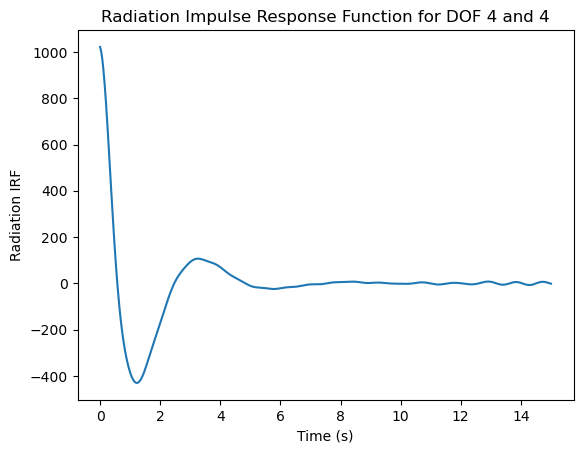

In [58]:
import matplotlib.pyplot as plt

# 假设您选择的自由度 i 和 j 是 0 和 1
i, j = 4, 4
plt.plot(irf['ra_t'], irf['ra_K'][: ,i, j]/1025)

plt.xlabel('Time (s)')
plt.ylabel('Radiation IRF')
plt.title(f'Radiation Impulse Response Function for DOF {i} and {j}')
plt.show()

In [64]:
irf['Ainf'].values/1000

array([[ 7.01044709e+01,  2.08151804e-17, -6.04316631e-07,
        -4.87600578e-12,  1.40170644e+02,  1.43771567e-19],
       [-7.87045074e-19,  7.01044709e+01, -2.59544254e-16,
        -1.40170644e+02, -4.87590162e-12,  2.08158671e-12],
       [-1.13664728e-06, -2.79082300e-16,  1.31408818e+02,
        -2.36100205e-15, -2.27262140e-06,  1.35743275e-11],
       [-4.85948908e-12, -1.40170552e+02, -7.60994305e-16,
         2.80264765e+02,  3.24667512e-14, -4.16820354e-12],
       [ 1.40170552e+02, -4.85949130e-12, -1.20832207e-06,
        -3.24633610e-14,  2.80264765e+02,  2.90747214e-19],
       [-9.13160675e-19,  1.57206172e-10,  1.35973934e-11,
        -3.14426532e-10, -1.82481444e-18,  2.35551224e-08]])

In [59]:
irf = radiationIRFSS(irf, Omax=None, R2t=None)

r2 -0.22179870695824944
r2 -0.22511916479727145
r2 -0.22502662764298287
r2 -0.22502204566118378
r2 -0.22499988187024855
r2 -0.22489244125949415
r2 -0.2249548891672446
r2 -0.22503510691790618
r2 -0.225206375279686
r2 0.048063422079241414
r2 0.02735180658421288
r2 -0.2185236414348084
r2 -0.2121156315117052
r2 -0.21964669586481578
r2 -0.25270221213562105
r2 -0.2170439989770403
r2 -0.27763922358520077
r2 -0.2930738985183292
r2 -0.117772390930456
r2 -0.16599203381397332
r2 0.08326027861773977
r2 0.09219740693209533
r2 0.031100423525838305
r2 0.06857397890715511
r2 -0.1749794490396801
r2 -0.17637081138346655
r2 -0.1814177044418681
r2 -0.17147898280024987
r2 -0.1720328142622567
r2 -0.17363636488997902
r2 -0.17344232092172596
r2 -0.17335872599640179
r2 -0.1734737960709023
r2 -0.17343397152747042
r2 -0.1734133316288935
r2 -0.1733853680221804
r2 -0.22180303953022595
r2 -0.22512406639564864
r2 -0.2250313694101671
r2 -0.22502679177239426
r2 -0.22500464361120853
r2 -0.2248972198093333
r2 -0.2249595

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

# 定义系统参数
m = 1.0  # 质量 (kg)
c = 0.1  # 阻尼系数 (Ns/m)
k = 10.0 # 刚度系数 (N/m)
F = 1.0  # 外力 (N)

# 定义卷积核函数 K(t)
def K(t):
    return np.exp(-t)  # 例如一个指数衰减函数

# 初始化历史速度的列表（全局变量）
history_y2 = []

# 定义方程组，包括卷积项
def system_equations_with_convolution(t, y):
    global history_y2
    y1, y2 = y
    dy1dt = y2

    # 更新历史速度列表
    history_y2.append((t, y2))

    # 计算卷积积分
    convolution_integral = sum(K(t - tau) * v * (t_eval[1] - t_eval[0]) for tau, v in history_y2)

    # 方程组
    dy2dt = (F - convolution_integral - c * y2 - k * y1) / m
    return [dy1dt, dy2dt]

# 初始条件
y0 = [0.0, 0.0]

# 定义时间区间
t_span = (0, 10)  # 从0到10秒
t_eval = np.linspace(*t_span, 500)  # 生成时间点

# 使用四阶Runge-Kutta方法 (RK45) 求解
solution = solve_ivp(system_equations_with_convolution, t_span, y0, t_eval=t_eval, method='RK45')

# 提取结果
t = solution.t
y1 = solution.y[0]
y2 = solution.y[1]

# 绘制结果图像
plt.figure(figsize=(12, 6))

# 位移图像
plt.subplot(2, 1, 1)
plt.plot(t, y1, label='位移 (m)')
plt.title('位移随时间的变化')
plt.xlabel('时间 (秒)')
plt.ylabel('位移 (米)')
plt.grid(True)
plt.legend()

# 速度图像
plt.subplot(2, 1, 2)
plt.plot(t, y2, label='速度 (m/s)', color='orange')
plt.title('速度随时间的变化')
plt.xlabel('时间 (秒)')
plt.ylabel('速度 (米/秒)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#求解算法
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 定义系统参数
m = 1.0  # 质量 (kg)
c = 0.1  # 阻尼系数 (Ns/m)
k = 10.0 # 刚度系数 (N/m)
F = 1.0  # 外力 (N)

# 生成卷积核K的时间序列
# 这里我们使用一个简单的衰减函数作为卷积核
def generate_convolution_kernel(time_points):
    return np.exp(-0.1 * time_points)

# 初始化历史速度的列表（全局变量）
history_y2 = []

# 定义方程组，包括卷积项
def system_equations_with_discrete_convolution(t, y, kernel_values):
    global history_y2
    y1, y2 = y
    dy1dt = y2

    # 更新历史速度列表
    history_y2.append((t, y2))

    # 计算卷积积分
    convolution_integral = sum(kernel_values[i] * v for i, (_, v) in enumerate(history_y2) if i < len(kernel_values))

    # 方程组
    dy2dt = (F - convolution_integral - c * y2 - k * y1) / m
    return [dy1dt, dy2dt]

# 时间区间
t_span = (0, 100)  # 从0到100秒
t_eval = np.linspace(*t_span, 1000)  # 生成时间点

# 生成卷积核时间序列
kernel_values = generate_convolution_kernel(t_eval)

# 清空历史速度列表
history_y2.clear()

# 使用RK45求解器求解
solution = solve_ivp(system_equations_with_discrete_convolution, t_span, y0, t_eval=t_eval, method='RK45', args=(kernel_values,))

# 提取结果
t = solution.t
y1 = solution.y[0]
y2 = solution.y[1]

# 绘制结果图像
plt.figure(figsize=(12, 6))

# 位移图像
plt.subplot(2, 1, 1)
plt.plot(t, y1, label='位移 (m)')
plt.title('位移随时间的变化')
plt.xlabel('时间 (秒)')
plt.ylabel('位移 (米)')
plt.grid(True)
plt.legend()

# 速度图像
plt.subplot(2, 1, 2)
plt.plot(t, y2, label='速度 (m/s)', color='orange')
plt.title('速度随时间的变化')
plt.xlabel('时间 (秒)')
plt.ylabel('速度 (米/秒)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

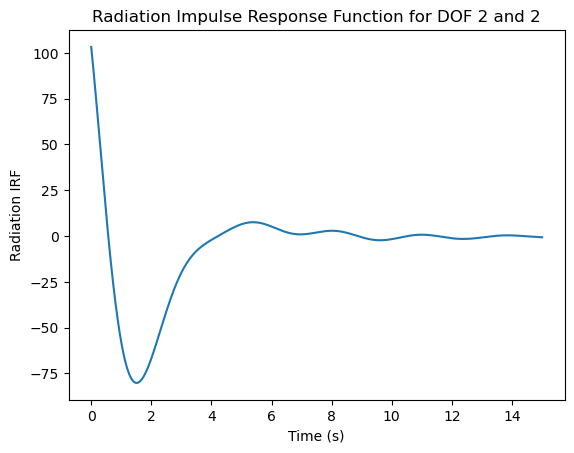

In [74]:
import matplotlib.pyplot as plt

# 假设您选择的自由度 i 和 j 是 0 和 1
i, j = 2, 2
plt.plot(irf['ra_t'], irf['ss_K'][i, j, :]/1025)
# plt.plot(irf['ra_t'], irf['ss_K'][i+6, j+6, :]/1025)
plt.xlabel('Time (s)')
plt.ylabel('Radiation IRF')
plt.title(f'Radiation Impulse Response Function for DOF {i} and {j}')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 假设您选择的自由度 i 和 j 是 0 和 1
i, j = 2,2
plt.plot(irf['ra_t'], irf['ra_K'][:, i, j]/1025)
plt.plot(irf['ra_t'], irf['ra_K'][:, i+6, j+6]/1025)
plt.xlabel('Time (s)')
plt.ylabel('Radiation IRF')
plt.title(f'Radiation Impulse Response Function for DOF {i} and {j}')
plt.show()

In [ ]:
#对比add mass
import matplotlib.pyplot as plt
# 假设您选择的自由度 i 和 j 是 0 和 1
i, j = 2, 2
plt.plot(irf['omega'], irf['added_mass'][:, i+6, j+6]/1025) #归一化
plt.plot(irf['omega'], irf['added_mass'][:, i+6, j+6]/1025)
plt.xlabel('omega')
plt.ylabel('added mass')
plt.legend(["1","2"])
plt.title(f'Added mass for A {i+1}{j+1}')
plt.show()

In [ ]:
# 对比阻尼系数
# 选择一个特定的自由度对 i 和 j
plt.plot(irf['omega'], irf['radiation_damping'][:, i, j]/(1025*irf['omega']))
plt.plot(irf['omega'], irf['radiation_damping'][:, i+6, j+6]/(1025*irf['omega']))
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Radiation Damping')
plt.title(f'Radiation Damping for DOF {i} and {j}')
plt.show()

In [ ]:
# 对比阻尼系数
# 选择一个特定的自由度对 i 和 j
plt.plot(irf['omega'], abs(irf['Froude_Krylov_force'][:, 0,i]+irf['diffraction_force'][:, 0,i])/(1025*9.81))
plt.plot(irf['omega'], abs(irf['Froude_Krylov_force'][:, 0,i]+irf['diffraction_force'][:, 0,i])/(1025*9.81))
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Radiation Damping')
plt.title(f'Radiation Damping for DOF {i}')
plt.show()

In [ ]:
#check hydrodynamic

#Bormalized radiation damping
import matplotlib.pyplot as plt
i,j = 4,4
plt.plot(dataset.omega,dataset['radiation_damping'].values[:,i,j]/(1025*dataset.omega))
plt.show()

#check Normalized added mass
import matplotlib.pyplot as plt
i,j = 4,4
plt.plot(dataset.omega,dataset['added_mass'].values[:,i,j]/(1025))
plt.show()